In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from torch.utils.data import DataLoader
from dataset.dataloader import CINE2DT
from model.model_pytorch import CRNN_MRI
# from utils import multicoil2single, compressed_sensing as cs,IFFT2c
from utils import multicoil2single, compressed_sensing as cs
from utils.dnn_io import to_tensor_format, from_tensor_format
from utils.fastmriBaseUtils import FFT2c,IFFT2c
from trainer_dcrnn_test import prep_input
from torch.autograd import Variable
import os 
from PIL import Image
# import scipy.io as sio
from scipy.io import loadmat
import scipy.io as scio
import h5py

os.environ['CUDA_VISIBLE_DEVICES'] = '3'  # 指定使用 GPU 1 和 GPU 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

## 将kgin_base生成的.npy转换为.mat格式  读取.mat格式文件并显示

In [31]:
import scipy.io as scio
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def load_mat(fn_im_path):
    """专业医学影像加载函数"""
    try:
        # 尝试用scipy加载传统格式
        f = scio.loadmat(fn_im_path)
        data_type = 'scipy_dict'
    except Exception:
        try:
            # 尝试加载HDF5格式
            f = h5py.File(fn_im_path, 'r')
            data_type = 'hdf5'
        except IOError as e:
            raise IOError(f"文件 {fn_im_path} 无法读取，请检查文件完整性。错误详情：{str(e)}")
    
    # 统一数据接口
    return {'data': f, 'type': data_type}

def display_medical_image(mat_path, var_name='image', slice_idx=None):
    """医学影像可视化函数"""
    # 加载数据
    loader = load_mat(mat_path)
    
    # 解析数据结构
    if loader['type'] == 'scipy_dict':
        # 处理传统MAT格式
        data_dict = loader['data']
        if var_name not in data_dict:
            raise KeyError(f"变量 {var_name} 不存在，可用变量：{list(data_dict.keys())}")
        image = data_dict[var_name]
    else:
        # 处理HDF5格式
        h5_file = loader['data']
        if var_name not in h5_file:
            raise KeyError(f"变量 {var_name} 不存在，可用变量：{list(h5_file.keys())}")
        image = np.array(h5_file[var_name])
    #image-shape: (192, 192, 18, 118)--生成的kgin_base_1209_r8_recon.mat
    print('image-shape:',image.shape) #image-shape: (118, 18, 192, 192)
    # 数据维度验证
    if image.ndim not in [2, 3, 4]:
        raise ValueError(f"不支持的维度 {image.shape}，仅支持2D/3D/4D医学影像")
    
    # 自动选择显示切片
    if image.ndim >= 3:
        if slice_idx is None:
            # 取中间层
            slice_idx = image.shape[-1] // 2
        # image = image[..., slice_idx]
        # image = image[slice_idx,0,:,:]
        image = image[:,:,0,80]
    
    # 转置维度适配显示 (MATLAB的列优先 -> Python的行优先)
    image = np.transpose(image) if image.ndim == 2 else image
    print('image-shape-2:',image.shape) #image-shape-2: (192, 192)
    # 医学影像标准化
    vmin, vmax = np.percentile(image, [1, 99])
    image_display = np.clip((image - vmin) / (vmax - vmin), 0, 1)
    
    # 可视化
    plt.figure(figsize=(6, 6))
    plt.imshow(image_display, cmap='gray', vmin=0, vmax=1)
    plt.title(Path(mat_path).name)
    plt.axis('off')
    plt.colorbar(label='信号强度 (a.u.)')
    plt.show()
    
    data_t_3_np = np.abs(image)  # 取模
    # 显示图像域的数据
    plt.figure(figsize=(6, 6))
    plt.imshow(data_t_3_np, cmap='gray')  # 使用灰度颜色映射
    plt.title("data_t_3_np  (第 0 帧)")
    plt.axis('off')
    plt.show()

image-shape: (192, 192, 18, 118)
image-shape-2: (192, 192)


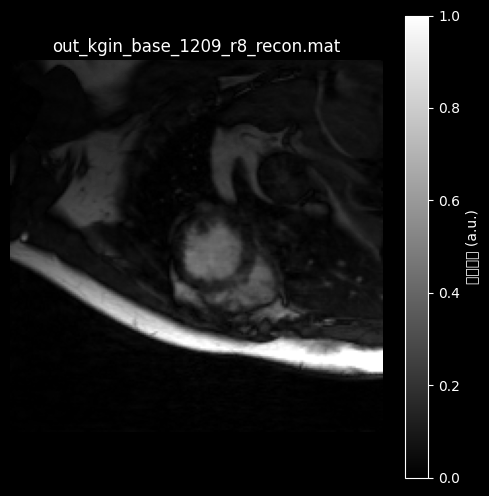

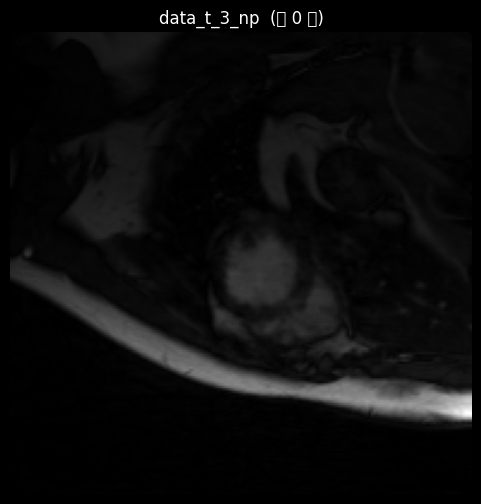

In [32]:
# 使用示例
if __name__ == "__main__":
    # mat_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r10/out_kgin_base_0118_r10_image.mat"
    # mat_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/out_kgin_base_1209_r8_image.mat'
    mat_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/converted_images/out_kgin_base_1209_r8_recon.mat'
    
    try:
        # 自动检测变量名
        test_data = scio.loadmat(mat_path)
        candidate_vars = [k for k in test_data.keys() if not k.startswith('__')]
        var_name = candidate_vars[0] if candidate_vars else 'image'
        
        # 显示图像
        display_medical_image(mat_path, var_name=var_name)
        
    except Exception as e:
        print(f"错误发生：{str(e)}")
        print("建议排查步骤：")
        print("1. 检查文件路径是否正确")
        print("2. 使用h5py查看文件结构：")
        print(f"   with h5py.File('{mat_path}', 'r') as f: print(f.keys())")
        print("3. 验证数据是否为浮点型数组")

## 以图片形式显示dccnn ls

(118, 192, 192, 18) complex64


/data0/zhiyong/software/Anaconda3_2024/envs/k_gin_zzy/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/data0/zhiyong/software/Anaconda3_2024/envs/k_gin_zzy/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24103 (\N{CJK UNIFIED IDEOGRAPH-5E27}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


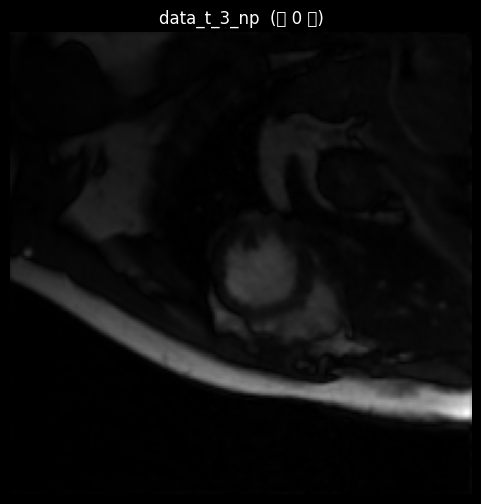

In [15]:
##显示dccnn ls
file_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn/dccnn_acc_8_merge.npy'
data = np.load(file_path)
print(data.shape,data.dtype) #(118, 192, 192, 18) complex64

data_t_3_np = np.abs(data[80,:,:,0])  # 取模
# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(data_t_3_np, cmap='gray')  # 使用灰度颜色映射
plt.title("data_t_3_np  (第 0 帧)")
plt.axis('off')
plt.show()


## 保存初始的CMR数据为label图片

In [ ]:
def load_mat(fn_im_path):
    try:
        f = scio.loadmat(fn_im_path)
    except Exception:
        try:
            f = h5py.File(fn_im_path, 'r')
        except IOError:
            # print("File {} is defective and cannot be read!".format(fn_im_path))
            raise IOError("File {} is defective and cannot be read!".format(fn_im_path))
    return f

## 原始kspace和csm保存为图片（label）
# 加载 k-space 数据和线圈灵敏度图
#  train_subjs: '/nfs/zzy/data/k_gin_data/k_cine_multicoil_training.npy' # a demo
#   train_maps: '/nfs/zzy/data/k_gin_data/csm_cine_multicoil_training.npy' # a demo
#   val_subjs: '/nfs/zzy/data/k_gin_data/k_cine_multicoil_test.npy' # a demo
#   val_maps: '/nfs/zzy/data/k_gin_data/csm_cine_multicoil_test.npy' # a demo
# data = np.load('/nfs/zzy/data/k_gin_data/k_cine_multicoil_test.npy')
# csm = np.load('/nfs/zzy/data/k_gin_data/csm_cine_multicoil_test.npy')
  # train_subjs: '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_training.npy' # a demo
  # train_maps: '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_training.npy' # a demo
  # val_subjs: '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy' # a demo
  # val_maps: '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_test.npy' # a demo
data = np.load('/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy')
csm = np.load('/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_test.npy')
print("data-shape-dtype:", data.shape,data.dtype)  # data: (800, coil=20, 18, 192, 192) (t,h,w)=(18, 192, 192)
print("csm-shape-dtype:", csm.shape,csm.dtype)  # data: (800, coil=20, 18, 192, 192) (t,h,w)=(18, 192, 192)

# 只取第一个样本
data = data[0, :, :, :, :]  # (coil=20, 18, 192, 192)
csm = csm[0, :, :, :, :]    # (coil=20, 18, 192, 192)

# 对 k-space 数据进行逆傅里叶变换，并与 CSM 结合生成图像
img = np.sum(IFFT2c(data) * np.conj(csm), axis=0)  # (18, 192, 192)
print("img:", img.shape)  # img: (18, 192, 192)

img = np.abs(img)  # 取模值显示

# 创建输出目录
output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base'
os.makedirs(output_dir, exist_ok=True)

# 保存前五帧的两种版本
for i in range(5):
    # 原始归一化
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_original.png'),
        img[i], 
        cmap='gray',
        vmin=0, 
        vmax=np.max(img)  # 保持动态范围一致
    )
    
    # 亮度增强版（3倍亮度）
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_brightened.png'),
        np.clip(img[i] * 3, 0, np.max(img)),  # 限制最大值不超过原始最大值
        cmap='gray'
    )

print(f"图像已保存至：{output_dir}")

# 归一化并调整亮度
# img_max = np.max(np.abs(img))
# img_norm = np.abs(img) / img_max
# brightness_factor = 3
# img_brightened = np.clip(img_norm * brightness_factor, 0, 1)

# # 创建 base 目录
# output_dir = 'base'
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # 保存前五张图片
# for i in range(5):
#     plt.imshow(img_brightened[i], cmap='gray')
#     plt.title(f'Frame {i}')
#     plt.axis('off')
#     plt.savefig(os.path.join(output_dir, f'frame_{i}.png'))  # 保存为 PNG 文件
#     plt.close()  # 关闭当前图像，避免重叠

# print(f"前五张图片已保存到 {output_dir} 目录下。")

data-shape-dtype: (118, 20, 18, 192, 192) complex64
csm-shape-dtype: (118, 20, 1, 192, 192) complex64
img: (18, 192, 192)
图像已保存至：/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base


## 将label保存为.npy何.mat格式（合并后保存一个文件）

In [ ]:
import numpy as np
import h5py
import os
from tqdm import tqdm

##代码可能有问题  需要调整
def IFFT2c(data):
    """优化的二维逆傅里叶变换（支持多线圈并行处理）"""
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(data, axes=(-2, -1))), axes=(-2, -1))

def save_hdf5_mat(file_path, data_dict, compression='gzip'):
    """专业级HDF5 .mat文件保存函数"""
    with h5py.File(file_path, 'w') as f:
        for key, value in data_dict.items():
            # 处理复数数据类型
            if np.iscomplexobj(value):
                # 创建符合MATLAB读取规范的复数数据集
                grp = f.create_group(key)
                grp.attrs['MATLAB_class'] = 'double'
                grp.create_dataset('real', data=value.real.astype(np.float64), 
                                  compression=compression)
                grp.create_dataset('imag', data=value.imag.astype(np.float64),
                                  compression=compression)
            else:
                # 实数数据直接存储
                f.create_dataset(key, data=value.astype(np.float64),
                                compression=compression)

def process_full_dataset():
    # 配置路径
    data_path = '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy'
    csm_path = '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_test.npy'
    output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base'
    
    os.makedirs(output_dir, exist_ok=True)

    # 加载完整数据集
    print("⌛ 加载数据文件中...")
    k_data = np.load(data_path)  # 形状 (N, 20, 18, 192, 192)
    csm_data = np.load(csm_path) # 形状同上
    print("✅ 数据加载完成")
    print(f"📊 数据维度: k-space={k_data.shape}, CSM={csm_data.shape}")

    # 参数解析
    N_samples, N_coils, N_t, N_x, N_y = k_data.shape
    recon_imgs = np.zeros((N_samples, N_t, N_x, N_y), dtype=np.complex64)

    # 处理流水线
    print("🔧 开始处理所有样本:")
    for sample_idx in tqdm(range(N_samples), desc='Processing'):
        # 当前样本数据
        k = k_data[sample_idx]      # (20, 18, 192, 192)
        csm = csm_data[sample_idx]  # (20, 18, 192, 192)
        
        # 重建流程
        ifft = IFFT2c(k)                      # 逆傅里叶变换
        combined = np.sum(ifft * np.conj(csm), axis=0)  # 线圈合并
        recon_imgs[sample_idx] = combined     # 存储结果

    # 转换为MATLAB兼容格式 (samples, y, x, time)
    matlab_format = recon_imgs.transpose(0, 3, 2, 1).astype(np.complex64)

    # 保存结果
    print("💾 保存输出文件...")
    # 保存为.npy
    np.save(os.path.join(output_dir, 'full_reconstructions.npy'), recon_imgs)
    
    # 保存为HDF5 .mat (v7.3)
    save_hdf5_mat(
        os.path.join(output_dir, 'full_reconstructions.mat'),
        {'recon_images': matlab_format},
        compression='gzip'
    )

    print(f"""
🎉 处理完成！文件已保存至：
   - Numpy文件: {os.path.join(output_dir, 'full_reconstructions.npy')}
   - MATLAB文件: {os.path.join(output_dir, 'full_reconstructions.mat')}
    """)

# if __name__ == "__main__":
    # process_full_dataset()
    
# import numpy as np
# import h5py
# import scipy.io as scio
# from tqdm import tqdm  # 进度条支持

# # def IFFT2c(data):
# #     """专业的二维逆傅里叶变换（支持批量处理）"""
# #     return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(data, axes=(-2, -1))), axes=(-2, -1))

# def process_and_save_full_data():
#     # 数据路径配置
#     data_path = '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy'
#     csm_path = '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_test.npy'
#     output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base'
    
#     # 创建输出目录
#     os.makedirs(output_dir, exist_ok=True)

#     # 加载完整数据
#     print("Loading data...")
#     full_kdata = np.load(data_path)      # (N=800, 20, 18, 192, 192)
#     full_csm = np.load(csm_path)         # 维度同上
#     print(f"原始数据维度 - k-space: {full_kdata.shape}, CSM: {full_csm.shape}")

#     # 预分配内存
#     N_samples, N_coils, N_t, N_x, N_y = full_kdata.shape
#     recon_imgs = np.empty((N_samples, N_t, N_x, N_y), dtype=np.complex64)

#     # 批量处理所有样本
#     print("Processing all samples:")
#     for sample_idx in tqdm(range(N_samples)):
#         # 提取当前样本数据
#         k_data = full_kdata[sample_idx]  # (20, 18, 192, 192)
#         csm_data = full_csm[sample_idx]  # 维度同上
        
#         # 执行图像重建
#         ifft_data = IFFT2c(k_data)       # 逆傅里叶变换
#         combined_img = np.sum(ifft_data * np.conj(csm_data), axis=0)  # 线圈合并
#         recon_imgs[sample_idx] = combined_img

#     # 转换为MATLAB兼容格式
#     # matlab_data = {
#     #     'recon_images': recon_imgs.transpose(0,2,3,1).astype(np.complex64),  # 维度转换为 (800,192,192,18)
#     #     'parameters': {
#     #         'samples': N_samples,
#     #         'coils': N_coils,
#     #         'time_points': N_t,
#     #         'spatial_resolution': [N_x, N_y]
#     #     }
#     # }

#     # 保存为.npy文件
#     np.save(os.path.join(output_dir, 'full_reconstructions.npy'), recon_imgs)
    
#     # 保存为.mat文件（v7.3格式支持大文件）
#     # scio.savemat(os.path.join(output_dir, 'full_reconstructions.mat'), 
#     #             matlab_data,
#     #             do_compression=True,
#     #             format='7.3')
    
#     print(f"\n数据保存完成: \n"
#           f"- Numpy格式: {os.path.join(output_dir, 'full_reconstructions.npy')}\n"
#           f"- MATLAB格式: {os.path.join(output_dir, 'full_reconstructions.mat')}")

# # if __name__ == "__main__":
# #     import os
# #     process_and_save_full_data()

# import h5py
# import numpy as np

# def save_as_mat_v73(file_path, data_dict):
#     """专业级HDF5格式(.mat v7.3)保存函数"""
#     with h5py.File(file_path, 'w') as f:
#         for key, value in data_dict.items():
#             # 处理复数数据（MATLAB兼容格式）
#             if np.iscomplexobj(value):
#                 f.create_dataset(f'{key}_real', data=value.real)
#                 f.create_dataset(f'{key}_imag', data=value.imag)
#             else:
#                 f.create_dataset(key, data=value,
#                                 compression='gzip',  # 启用压缩
#                                 chunks=True)  # 支持分块读取

# # 修改后的保存代码
# matlab_data = {
#     'recon_images': recon_imgs.transpose(0,3,2,1).astype(np.complex64)  # 转换为MATLAB维度顺序 (samples, y, x, time)
# }

# save_as_mat_v73(os.path.join(output_dir, 'full_reconstructions.mat'), matlab_data)

In [13]:
process_full_dataset()

⌛ 加载数据文件中...
✅ 数据加载完成
📊 数据维度: k-space=(118, 20, 18, 192, 192), CSM=(118, 20, 1, 192, 192)
🔧 开始处理所有样本:


Processing: 100%|██████████| 118/118 [01:40<00:00,  1.18it/s]


💾 保存输出文件...

🎉 处理完成！文件已保存至：
   - Numpy文件: /data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/full_reconstructions.npy
   - MATLAB文件: /data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/full_reconstructions.mat
    


## 合并DCCNN、CRNN结果

In [ ]:
import numpy as np
import scipy.io as sio
import os
import re  # 新增正则表达式模块
from tqdm import tqdm

###ls用后面的代码
# 输入路径
input_dir = "/data0/zhiyong/data/CMR_data/single_coil/d5c5_acc_8/"
output_dir = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn"

# 创建输出目录
os.makedirs(output_dir, exist_ok=True)

# 获取所有 .mat 文件并按数字排序（使用正则表达式过滤无效文件）
mat_files = sorted(
    [f for f in os.listdir(input_dir) 
     if re.match(r'^recon_(\d+)\.mat$', f)],  # 仅匹配 recon_数字.mat
    key=lambda x: int(re.search(r'(\d+)', x).group(1))  # 提取数字部分排序
)

# 初始化合并后的数据列表
merged_data = []

# 逐个加载并合并
for mat_file in tqdm(mat_files, desc="合并进度"):
    mat_path = os.path.join(input_dir, mat_file)
    data = sio.loadmat(mat_path)
    
    # 假设数据字段为 'recon'（需根据实际字段名调整）
    recon = data['recon']
    merged_data.append(recon)

# 转换为 NumPy 数组（维度示例: [num_samples, height, width]）
merged_array = np.array(merged_data)

# 保存为 .npy 文件
np.save(os.path.join(output_dir, "dccnn_acc_8_merge.npy"), merged_array)

# 保存为 .mat 文件（兼容 MATLAB）
sio.savemat(
    os.path.join(output_dir, "dccnn_acc_8_merge.mat"),
    {"merged_recon": merged_array},
    do_compression=True
)

print(f"合并完成！有效文件数量：{len(mat_files)}，输出目录：{output_dir}")

合并进度:   0%|          | 0/118 [00:00<?, ?it/s]


NotImplementedError: Please use HDF reader for matlab v7.3 files, e.g. h5py

## 使用 scipy.io.loadmat 读取 MATLAB v7.3 格式的 .mat 文件，而该格式基于 HDF5，需要改用 h5py 库读取。

In [2]:
import numpy as np
import h5py
import os
import re
from tqdm import tqdm

input_dir = "/data0/zhiyong/data/CMR_data/single_coil/ls_acc_8"
output_dir = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls"

os.makedirs(output_dir, exist_ok=True)

mat_files = sorted(
    [f for f in os.listdir(input_dir) 
     if re.match(r'^recon_(\d+)\.mat$', f)],
    key=lambda x: int(re.search(r'(\d+)', x).group(1))
)

merged_data = []

for mat_file in tqdm(mat_files, desc="合并进度"):
    mat_path = os.path.join(input_dir, mat_file)
    # 使用 h5py 读取 v7.3 格式的 .mat 文件
    with h5py.File(mat_path, 'r') as f:
        recon = f['recon'][()]  # 获取数据
        # 调整维度顺序（MATLAB 使用 Fortran 列优先，需转置）
        recon = recon.T
    merged_data.append(recon)

merged_array = np.array(merged_data)

# 保存为 .npy 文件
np.save(os.path.join(output_dir, "ls_acc_8_merge.npy"), merged_array)

# 使用 h5py 保存为 v7.3 格式的 .mat 文件（兼容 MATLAB）
with h5py.File(os.path.join(output_dir, "ls_acc_8_merge.mat"), 'w') as f:
    f.create_dataset('merged_recon', data=merged_array, compression='gzip')

print(f"合并完成！有效文件数量：{len(mat_files)}，输出目录：{output_dir}")

合并进度: 100%|██████████| 118/118 [00:13<00:00,  8.88it/s]


合并完成！有效文件数量：118，输出目录：/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls


## 保存前五张照片(原始数据是图片格式)

In [7]:
from utils.fastmriBaseUtils import FFT2c,IFFT2c
# 这种方法是将上一级目录添加到模块搜索路径中，然后进行导入。
# import sys
# sys.path.append("..")
# from UTILS import FFT2c, IFFT2c
# from UTILS import FFT2C, IFFT2C
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def load_mat(fn_im_path):
    try:
        f = sio.loadmat(fn_im_path)
    except Exception:
        try:
            f = h5py.File(fn_im_path, 'r')
        except IOError:
            raise IOError("File {} is defective and cannot be read!".format(fn_im_path))
    return f

# 加载数据

# data = np.load('/nfs/zzy/code/k_gin_kv/output/r4/out_1220_r4.npy') #r4
# data = np.load('/nfs/zzy/code/k_gin_kv/output/r6/out_1205_r6_1.npy') # r6
# data = np.load('/nfs/zzy/code/k_gin_kv/output/r8/out_1205_2_r8.npy') #r8
## /data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/crnn_acc_8_merge.npy
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/ls_acc_12_merge.npy')
print("data-1-shape:", data.shape)  # data: (118, 192, 192, 18)  data: (800, coil=20, 18, 192, 192) (t,h,w)=(18, 192, 192)

# 只取第一帧数据
data = data[0:1, :, :, :]
# 检查数据是否为结构化数组  ls的结果是结构化数组
if data.dtype.names is not None and ('real' in data.dtype.names) and ('imag' in data.dtype.names):
    # 提取实部和虚部并合并为复数
    real_part = data['real']
    imag_part = data['imag']
    data_complex = real_part.astype(np.complex64) + 1j * imag_part.astype(np.complex64)
else:
    data_complex = data.astype(np.complex64)

# 调整维度顺序
data_complex = data_complex.transpose(0, 3, 1, 2)  # (batch, time, height, width)
# print('data-2-dtype:',data.dtype) #data-2-dtype: complex64
# print('data-2-shape:',data.shape) #data-2-shape: (1, 192, 192, 18)
# data = data.transpose(0,3,1,2)

# 对数据进行逆傅里叶变换
# img = IFFT2c(data)
# 应用逆傅里叶变换
# img = IFFT2c(data_complex)
img = data_complex[0]  # 取第一个样本
# img = data[0]
# img = img[0,:,:]  # 取第一个样本
print("img:", img.shape)  # img: (18, 192, 192)
print("img dtype:", img.dtype)  # 查看数据类型 img dtype: [('real', '<f4'), ('imag', '<f4')]

# 归一化并调整亮度
img_max = np.max(np.abs(img))
img_norm = np.abs(img) / img_max
brightness_factor = 3
img_brightened = np.clip(img_norm * brightness_factor, 0, 1)

# # 创建 r4 目录
# output_dir = 'r4'
# # 创建 r6 目录
# output_dir = 'r6'
# 创建 r6 目录
output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/r12'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 保存前五张图片
for i in range(5):
    plt.imshow(img_brightened[i], cmap='gray')
    plt.title(f'Frame {i}')
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, f'frame_{i}.png'))  # 保存为 PNG 文件
    plt.close()  # 关闭当前图像，避免重叠

print(f"前五张图片已保存到 {output_dir} 目录下。")

data-1-shape: (118, 192, 192, 18)
img: (18, 192, 192)
img dtype: complex64
前五张图片已保存到 /data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/r12 目录下。


In [22]:
from utils.fastmriBaseUtils import FFT2c, IFFT2c
import matplotlib.pyplot as plt
import numpy as np
import os

# 加载数据
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/ls_acc_8_merge.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn/dccnn_acc_10_merge.npy')
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/crnn_acc_12_merge.npy')
print('data-shape-1:',data.shape) #data-shape-1: (118, 192, 192, 18)
# 只取第一帧数据（保持4D结构）
data_subset = data[0:1]  # shape: (1, ...)
print('data_subset-shape-1:',data_subset.shape) #data_subset-shape-1: (1, 192, 192, 18)
print('data_subset-dtype-1:',data_subset.dtype) #data_subset-dtype-1: complex64

# 处理结构化数组（兼容旧数据格式）
if data_subset.dtype.names is not None:
    print('11111111111111')
    # 合并实部虚部为复数 (batch, h, w, time)
    data_complex = data_subset['real'].astype(np.complex64) + 1j * data_subset['imag'].astype(np.complex64)
    # data_complex = data_complex.transpose(0, 3, 1, 2)  # (batch, time, h, w)
else:
    print('2222222222')
    # 新格式直接转换 (假设维度已经是 [batch, time, h, w])
    data_complex = data_subset.astype(np.complex64)
data_complex = data_complex.transpose(0, 3, 1, 2)

# 应用逆傅里叶变换（如果数据是k空间）
# data_complex = IFFT2c(data_complex)  # 根据实际数据性质决定是否启用

# 提取第一个样本并调整维度顺序
img = data_complex[0]  # (time, h, w)
print('img-shape-1:',img.shape) #img-shape-1: (192, 192, 18)
img = np.abs(img)  # 取模值显示

# 创建输出目录
# output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/r8'
# output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn/r10'
output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/r12'
os.makedirs(output_dir, exist_ok=True)

# 保存前五帧的两种版本
for i in range(5):
    # 原始归一化
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_original.png'),
        img[i], 
        cmap='gray',
        vmin=0, 
        vmax=np.max(img)  # 保持动态范围一致
    )
    
    # 亮度增强版（3倍亮度）
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_brightened.png'),
        np.clip(img[i] * 3, 0, np.max(img)),  # 限制最大值不超过原始最大值
        cmap='gray'
    )

print(f"图像已保存至：{output_dir}")

data-shape-1: (118, 192, 192, 18)
data_subset-shape-1: (1, 192, 192, 18)
data_subset-dtype-1: complex64
2222222222
img-shape-1: (18, 192, 192)
图像已保存至：/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/r12


## 保存前五张照片(原始数据是kspace)

In [12]:
from utils.fastmriBaseUtils import FFT2c, IFFT2c
import matplotlib.pyplot as plt
import numpy as np
import os

# 加载数据
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/ls_acc_8_merge.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn/dccnn_acc_12_merge.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/out_1209r_8.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r10/out_kgin_base_0118_r10.npy')
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12/out_kgin_base_0118_r12.npy')
# 只取第一帧数据（保持4D结构）
data_subset = data[0:1]  # shape: (1, ...)

# 处理结构化数组（兼容旧数据格式）
if data_subset.dtype.names is not None:
    # 合并实部虚部为复数 (batch, h, w, time)
    data_complex = data_subset['real'].astype(np.complex64) + 1j * data_subset['imag'].astype(np.complex64)
    data_complex = data_complex.transpose(0, 3, 1, 2)  # (batch, time, h, w)
else:
    # 新格式直接转换 (假设维度已经是 [batch, time, h, w])
    data_complex = data_subset.astype(np.complex64)

# 应用逆傅里叶变换（如果数据是k空间）
# data_complex = IFFT2c(data_complex)  # 根据实际数据性质决定是否启用

# 提取第一个样本并调整维度顺序
# img = data_complex[0]  # (time, h, w)
img_complex = IFFT2c(data_complex)
img = np.abs(img_complex[0])  # 取模值显示

# 创建输出目录
# output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/r8'
# output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn/r12'
output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12'
os.makedirs(output_dir, exist_ok=True)

# 保存前五帧的两种版本
for i in range(5):
    # 原始归一化
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_original.png'),
        img[i], 
        cmap='gray',
        vmin=0, 
        vmax=np.max(img)  # 保持动态范围一致
    )
    
    # 亮度增强版（3倍亮度）
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_brightened.png'),
        np.clip(img[i] * 3, 0, np.max(img)),  # 限制最大值不超过原始最大值
        cmap='gray'
    )

print(f"图像已保存至：{output_dir}")

图像已保存至：/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12


## 计算两张MRI图像的PSNR（峰值信噪比）
### ​两种计算方法：
​手动计算：直接根据公式 PSNR = 20*log10(MAX) - 10*log10(MSE) 实现

​scikit-image库：使用现成的peak_signal_noise_ratio函数（更可靠）

### ​典型结果解读：
PSNR > 40 dB：重建质量优秀

30 dB < PSNR < 40 dB：质量可接受

PSNR < 30 dB：质量较差

In [ ]:
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio

# 图像路径
# label_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/frame_0.png"
label_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/frame_0_original.png'
# recon_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/r8/frame_0.png"
# recon_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/r4/frame_0.png'
recon_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/r8/frame_1_original.png'
# recon_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn/r12/frame_0_original.png'
# recon_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/frame_2_brightened.png'

try:
    # 读取图像（灰度模式）
    label_img = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    recon_img = cv2.imread(recon_path, cv2.IMREAD_GRAYSCALE)

    if label_img is None or recon_img is None:
        raise FileNotFoundError("无法读取图像文件，请检查路径是否正确")

    # 确保图像尺寸相同
    if label_img.shape != recon_img.shape:
        raise ValueError("图像尺寸不匹配")

    # 方法1：手动计算PSNR
    # mse = np.mean((label_img.astype(np.float64) - recon_img.astype(np.float64)) ​** 2)
    mse = np.mean((label_img.astype(np.float64) - recon_img.astype(np.float64))**2)
    print('mse:',mse)
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * np.log10(255.0 / np.sqrt(mse))

    # 方法2：使用scikit-image库（推荐）
    psnr_skimage = peak_signal_noise_ratio(label_img, recon_img, data_range=255)

    print(f"[手动计算] PSNR: {psnr:.2f} dB")
    print(f"[scikit-image] PSNR: {psnr_skimage:.2f} dB")

except Exception as e:
    print(f"错误: {str(e)}")

'''
ls:r8--36.41 r10--28.47 r12--28.37
dccnn:r8--36.96 r10--35.32 r12--34.96
'''

mse: 14.875678168402779
[手动计算] PSNR: 36.41 dB
[scikit-image] PSNR: 36.41 dB


'\nls:r8--36.92 r10--28.47 r2--28.37\ndccnn:r8--36.96 r10--35.32 r12--34.96\n'

In [ ]:
# im=[1,30,256,256]
# label_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/frame_0.png"
## /data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/crnn_acc_8_merge.npy
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/ls_acc_12_merge.npy')
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/crnn_acc_8_merge.npy')
print("data-1-shape:", data.shape)  # data: (118, 192, 192, 18)  data: (800, coil=20, 18, 192, 192) (t,h,w)=(18, 192, 192)

# 只取第一帧数据
data = data[0:1, :, :, :]
# 检查数据是否为结构化数组  ls的结果是结构化数组
if data.dtype.names is not None and ('real' in data.dtype.names) and ('imag' in data.dtype.names):
    # 提取实部和虚部并合并为复数
    real_part = data['real']
    imag_part = data['imag']
    data_complex = real_part.astype(np.complex64) + 1j * imag_part.astype(np.complex64)
else:
    data_complex = data.astype(np.complex64)

# 调整维度顺序
data_complex = data_complex.transpose(0, 3, 1, 2)  # (batch, time, height, width)
# print('data-2-dtype:',data.dtype) #data-2-dtype: complex64
# print('data-2-shape:',data.shape) #data-2-shape: (1, 192, 192, 18)
# data = data.transpose(0,3,1,2)

# 对数据进行逆傅里叶变换
# img = IFFT2c(data)
# 应用逆傅里叶变换
# img = IFFT2c(data_complex)
# im = data_complex[0]  # 取第一个样本
im = data_complex

###生成shear_grid 的mask
# print('im-shape:',im.shape)
acc = 8
mask = cs.shear_grid_mask(im.shape[1:], acc, sample_low_freq=True,centred=True,sample_n=4)
mask = np.repeat(mask[np.newaxis], im.shape[0], axis=0)
print('mask-shape-1:',mask.shape) #mask-shape: (1, 18, 192, 192)
mask = mask[0,:,:,:]
print('mask-shape-2:',mask.shape) #mask-shape: mask-shape-2: (18, 192, 192)

scio.savemat('masks/VISTA/shear_grid_18_192_192_sample_n_4_acc_8.mat', {'mask': mask})

# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(mask[0,0,:,:], cmap='gray')  # 使用灰度颜色映射
plt.title("mask -1  (第 0 帧)")
plt.axis('off')
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(mask[0,:,:,0], cmap='gray')  # 使用灰度颜色映射
plt.title("mask -1  (第 0 帧)")
plt.axis('off')
plt.show()

data-1-shape: (118, 192, 192, 18)
mask-shape-1: (1, 18, 192, 192)
mask-shape-2: (18, 192, 192)


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

<Figure size 600x600 with 0 Axes>

In [ ]:
import numpy as np
import torch

# 加载.npy文件
val_subjs = np.load('/nfs/zzy/data/k_gin_data/k_cine_multicoil_test.npy')
val_maps = np.load('/nfs/zzy/data/k_gin_data/csm_cine_multicoil_test.npy')

# 将numpy数组转换为PyTorch张量
val_subjs_tensor = torch.from_numpy(val_subjs)
val_maps_tensor = torch.from_numpy(val_maps)

# 查看维度
# val_subjs dimensions: torch.Size([118, 20, 18, 192, 192])
# val_maps dimensions: torch.Size([118, 20, 1, 192, 192])
'''
根据你提供的维度信息，每个维度可能有特定的含义，这通常取决于数据集的上下文。以下是根据常见的数据集和MRI（磁共振成像）数据的一般情况，对每个维度的可能含义的推测：
val_subjs dimensions: torch.Size([118, 20, 18, 192, 192])
第一个维度 [118]：可能表示数据集中的样本数量或不同的主题（subjects）。
第二个维度 [20]：可能表示每个样本的时间序列长度，或者不同的切片（slices）。
第三个维度 [18]：可能表示不同的通道（channels），在MRI数据中，这可能表示不同的线圈接收到的信号。 时间t
第四个维度 [192]：可能表示图像的高度。
第五个维度 [192]：可能表示图像的宽度。

val_maps dimensions: torch.Size([118, 20, 1, 192, 192])
第一个维度 [118]：与 val_subjs 的第一个维度相同，表示样本数量或不同的主题。
第二个维度 [20]：与 val_subjs 的第二个维度相同，表示时间序列长度或不同的切片。
第三个维度 [1]：表示通道数，这里只有一个通道，可能是一个单通道的映射（map），例如一个密度图或权重图。
第四个维度 [192]：与 val_subjs 的第四个维度相同，表示图像的高度。
第五个维度 [192]：与 val_subjs 的第五个维度相同，表示图像的宽度。
这些解释是基于一般的MRI数据处理和图像数据的维度约定。具体的含义可能依赖于数据集的文档或数据生成过程。
如果你有数据集的文档，建议查阅以获取确切的维度含义。如果文档不可用，你可能需要联系数据集的提供者或查看相关的研究论文来了解每个维度的具体含义。
'''
print("val_subjs dimensions:", val_subjs_tensor.shape)
print("val_maps dimensions:", val_maps_tensor.shape)


val_subjs dimensions: torch.Size([118, 20, 18, 192, 192])
val_maps dimensions: torch.Size([118, 20, 1, 192, 192])


data: (118, 18, 192, 192)
img: (18, 192, 192)


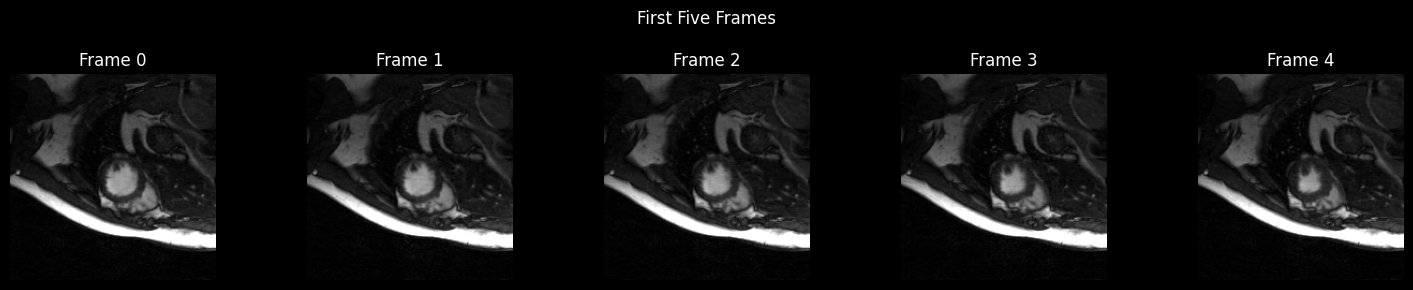

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 加载数据
# data = np.load('/nfs/zzy/code/k_gin_base/output/r4/out_1220_r4.npy')
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r4/out_1220_r4.npy')
print("data:", data.shape)  # data: (800, coil=20, 18, 192, 192) (t,h,w)=(18, 192, 192)

# 选择数据的一个切片
# data = data[100:101, :, :, :]
data = data[80:81, :, :, :]
# data = data[0:1, :, :, :]

# 假设 IFFT2c 是一个函数，用于计算逆傅里叶变换
# 由于代码中没有提供 IFFT2c 函数的定义，这里假设它已经定义好了
img = IFFT2c(data)
img = img[0]
print("img:", img.shape)

# 归一化并增强亮度
img_max = np.max(np.abs(img))
img_norm = np.abs(img) / img_max
brightness_factor = 3
img_brightened = np.clip(img_norm * brightness_factor, 0, 1)

# 创建一个图像网格来显示前五张图片
fig, axs = plt.subplots(1, 5, figsize=(15, 3))  # 1行5列的子图
fig.suptitle('First Five Frames')  # 设置总标题

# 遍历前五张图片并显示在子图中
for i in range(5):
    axs[i].imshow(img_brightened[i], cmap='gray')
    axs[i].set_title(f'Frame {i}')
    axs[i].axis('off')  # 关闭坐标轴

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整布局以避免标题重叠
plt.show()


## 顺时针旋转90度显示

data: (118, 18, 192, 192)


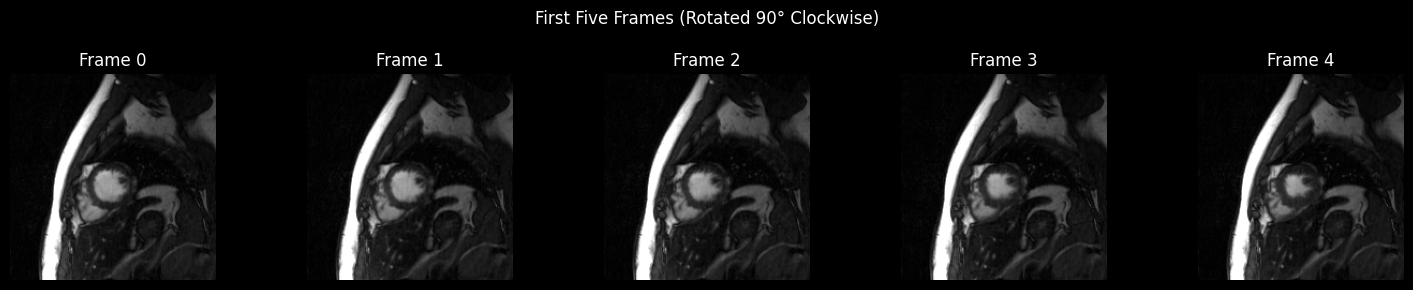

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 加载数据
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r4/out_1220_r4.npy')
print("data:", data.shape)  # data: (800, coil=20, 18, 192, 192)

# 选择数据的一个切片
data = data[80:81, :, :, :]

# 逆傅里叶变换
img = IFFT2c(data)
img = img[0]  # 取第一个样本，形状 (18, 192, 192)

# 归一化并增强亮度
img_max = np.max(np.abs(img))
img_norm = np.abs(img) / img_max
brightness_factor = 3
img_brightened = np.clip(img_norm * brightness_factor, 0, 1)

# 创建子图
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle('First Five Frames (Rotated 90° Clockwise)')

# 显示前五帧（旋转后）
for i in range(5):
    # 顺时针旋转90度（两种等效方式）：
    # 方法一：使用 np.rot90 旋转270度（即逆时针270度=顺时针90度）
    rotated_frame = np.rot90(img_brightened[i], k=3) 
    
    # 方法二：转置后水平翻转（更高效）
    # rotated_frame = img_brightened[i].T[::-1, :]
    
    axs[i].imshow(rotated_frame, cmap='gray')
    axs[i].set_title(f'Frame {i}')
    axs[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 将.npy文件（图片）转换为.mat格式  不适用于kgin_base生成的文件(kgin_base保存的为kspace)

In [14]:
import numpy as np
import scipy.io

def convert_npy_to_mat(npy_path, mat_path=None, var_name='mask_data'):
    """
    专业级.npy转.mat转换器
    
    参数:
    npy_path : str       输入.npy文件路径
    mat_path : str       [可选]输出.mat路径 
    var_name : str       [可选]MATLAB变量名
    
    返回:
    mat保存路径
    """
    try:
        # 加载数据并验证完整性
        data = np.load(npy_path)
        if not isinstance(data, np.ndarray):
            raise ValueError("非标准numpy数组格式")
            
        # 自动生成输出路径
        if mat_path is None:
            mat_path = npy_path.replace('.npy', '.mat')
            
        # 保持维度一致性 (Matlab兼容处理)
        if data.ndim >= 3:
            data = np.transpose(data, axes=tuple(range(data.ndim-1, -1, -1)))
            
        # 保存为MATLAB v7.3格式 (支持>2GB数据)
        scipy.io.savemat(mat_path, 
                        {var_name: data},
                        appendmat=False,
                        do_compression=True)
                        
        print(f"转换成功: {npy_path} -> {mat_path}")
        return mat_path
        
    except Exception as e:
        print(f"转换失败: {str(e)}")
        return None



In [ ]:
# 执行转换
input_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/out_1209r_8.npy"
# input_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r10/out_kgin_base_0118_r10.npy"
# input_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12/out_kgin_base_0118_r12.npy"

# input_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_kv/output/cine_mask/r8/out_kgin_kv_r8.npy'
# input_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_kv/output/cine_mask/r10/out_kgin_kv_0118_r10.npy'
# input_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_kv/output/cine_mask/r12/out_kgin_kv_0118_r12.npy'
# input_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/full_reconstructions.npy'
# mat_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/'
output_path = convert_npy_to_mat(input_path)

转换成功: /data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/full_reconstructions.npy -> /data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/full_reconstructions.mat


## 将.npy文件（kspace）转换为.mat格式 适用于kgin_base生成的文件

In [ ]:
import numpy as np
import scipy.io
import numpy.fft as fft
from pathlib import Path

def ifft2c(kspace):
    """专业的2D逆傅里叶变换，兼容MRI数据处理"""
    return fft.fftshift(fft.ifft2(fft.ifftshift(kspace, axes=(-2, -1))), axes=(-2, -1))

def convert_kspace_to_image(npy_path, output_dir=None, formats=('npy', 'mat'), var_name='image'):
    """
    专业k-space转换器（支持多格式输出）
    
    参数:
    npy_path : str       输入.npy文件路径（复数k-space数据）
    output_dir : str     输出目录（默认同输入目录）
    formats : tuple      输出格式，可选'npy'/'mat'（默认双格式）
    var_name : str       MATLAB变量名
    
    返回:
    dict {格式: 保存路径}
    """
    try:
        # 输入验证
        kspace = np.load(npy_path)
        print('kspace-shape:',kspace.shape) #kspace-shape: (118, 18, 192, 192)
        if not np.iscomplexobj(kspace):
            raise ValueError("输入数据必须为复数k-space")
            
        # 执行图像重建
        image_complex = ifft2c(kspace)
        image = np.abs(image_complex)
        image = image / np.max(image)  # 标准化到[0,1]
        print('image-shape:',image.shape) #image-shape: (118, 18, 192, 192)

        # 准备输出路径
        input_path = Path(npy_path)
        output_dir = Path(output_dir) if output_dir else input_path.parent
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # 生成基础文件名
        base_name = input_path.stem + '_recon'
        save_paths = {}

        # 保存为.npy格式（保留原始维度）
        if 'npy' in formats:
            npy_path = output_dir / f"{base_name}.npy"
            print('npy_path:',npy_path) #npy_path: converted_images/out_kgin_base_1209_r8_recon.npy
            np.save(npy_path, image.astype(np.float32))  # 使用float32节省空间
            save_paths['npy'] = str(npy_path)
        print('save npy success------')
        # 保存为.mat格式（适配MATLAB维度）
        # if 'mat' in formats:
        #     # 调整维度顺序 (height, width) -> (width, height)
        #     mat_image = image.T if image.ndim == 2 else np.transpose(image, (1, 0, 2))
        #     print('mat_image-shape:',mat_image.shape)
        #     mat_path = output_dir / f"{base_name}.mat"
        #     scipy.io.savemat(str(mat_path), 
        #                    {var_name: mat_image.astype(np.float32)},
        #                    appendmat=False,
        #                    do_compression=True)
        #     save_paths['mat'] = str(mat_path)
        # 保存为.mat格式（专业医学影像适配）
        if 'mat' in formats:
            # 智能维度转置 (相位编码方向适配)
            if image.ndim == 4:
                # 假设维度为 [slices, echoes, PE, RO] → [RO, PE, echoes, slices]
                mat_image = np.transpose(image, (3, 2, 1, 0))
                print(f"MATLAB适配维度: {mat_image.shape}")  # MATLAB适配维度: (192, 192, 18, 118)
            else:
                raise ValueError("不支持的维度，仅支持4D医学影像")
                
            mat_path = output_dir / f"{base_name}.mat"
            scipy.io.savemat(str(mat_path), 
                           {var_name: mat_image.astype(np.float32)},
                           appendmat=False,
                           do_compression=True,
                           oned_as='column')  # 重要参数：保持向量方向
            save_paths['mat'] = str(mat_path)
            
        print(f"转换成功: {npy_path}")
        print(f"输出文件: {save_paths}")
        return save_paths
        
    except Exception as e:
        # print(f"转换失败: {str(e)}")
        print(f"转换失败: {str(e)}")
        print("医学影像处理建议:")
        print("1. 验证k-space维度顺序是否符合 [slices, echoes, PE, RO]")
        print("2. 使用MITK或Horos软件验证输出.mat文件")
        return None



In [ ]:
# # 使用示例
# # input_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/out_kgin_base_1209r_8.npy"
# input_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12/out_kgin_base_0118_r12.npy"
# # /data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12/out_kgin_base_0118_r12.npy
# output_path = convert_kspace_to_image(input_path)
# 使用示例
## /data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r10/out_kgin_base_0118_r10.npy
## /data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12/out_kgin_base_0118_r12.npy
# input_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/out_kgin_base_1209_r8.npy"
input_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12/out_kgin_base_0118_r12.npy'
output = convert_kspace_to_image(
    input_path,
    output_dir="./converted_images",
    formats=('npy', 'mat')
)

kspace-shape: (118, 18, 192, 192)
image-shape: (118, 18, 192, 192)
npy_path: converted_images/out_kgin_base_0118_r10_recon.npy
save npy success------
MATLAB适配维度: (192, 192, 18, 118)
转换成功: converted_images/out_kgin_base_0118_r10_recon.npy
输出文件: {'npy': 'converted_images/out_kgin_base_0118_r10_recon.npy', 'mat': 'converted_images/out_kgin_base_0118_r10_recon.mat'}


In [16]:
# 数据校验模块
def verify_conversion(npy_path, mat_path):
    """专业级数据校验"""
    py_data = np.load(npy_path)
    mat_data = scipy.io.loadmat(mat_path)['mask_data']
    
    # 维度校正比较
    if py_data.ndim >= 3:
        py_data = np.transpose(py_data, axes=tuple(range(py_data.ndim-1, -1, -1)))
    
    return np.allclose(py_data, mat_data, atol=1e-6)

# npy_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/out_1209r_8.npy"
# mat_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/out_1209r_8.mat"
npy_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/full_reconstructions.npy'
mat_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/full_reconstructions.mat'
verify_res = verify_conversion(npy_path,mat_path)
print('verify_res:',verify_res)

verify_res: True


IndexError: index 4 is out of bounds for axis 0 with size 4

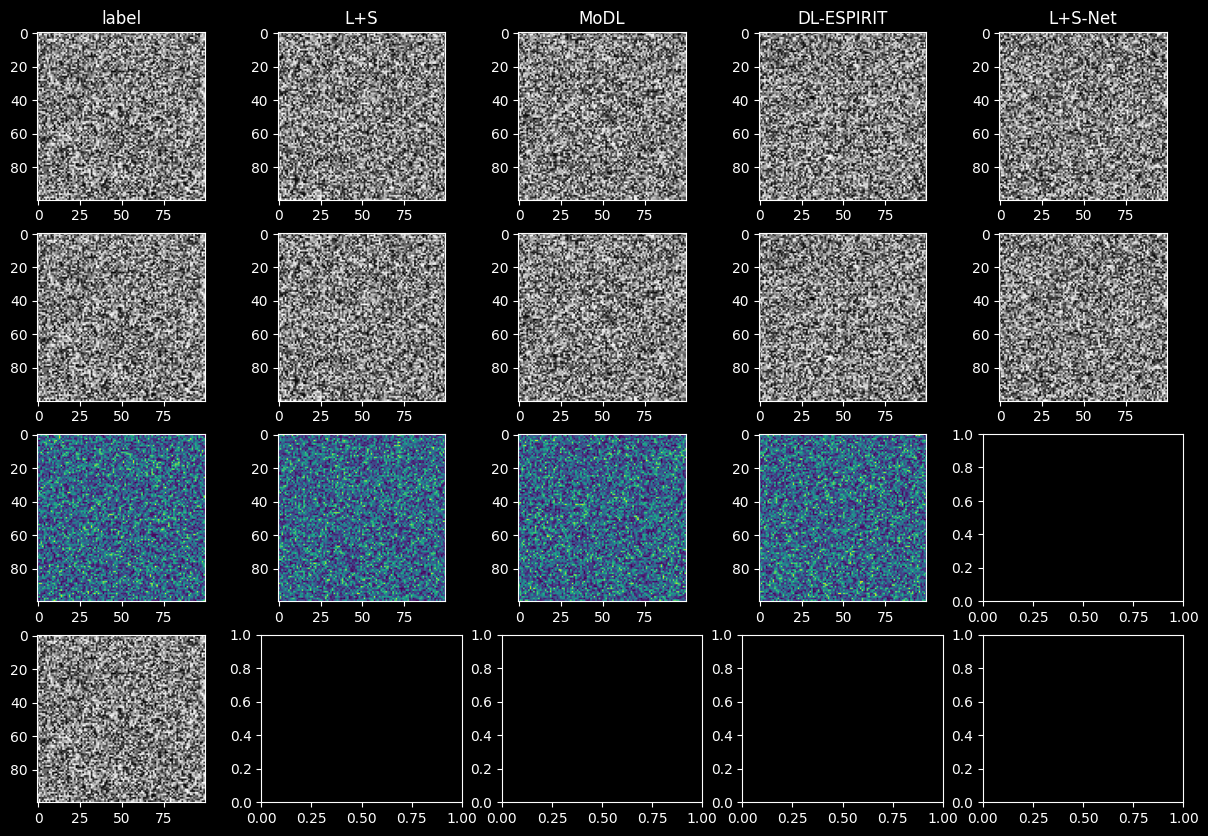

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 模拟生成一些示例数据，实际中需替换为真实数据读取  ---数据还未整理，暂不用这个代码！！！
label_image = np.random.rand(100, 100)
l_plus_s_image = np.random.rand(100, 100)
modl_image = np.random.rand(100, 100)
dl_espirit_image = np.random.rand(100, 100)
l_plus_s_net_image = np.random.rand(100, 100)

# 假设已经计算好误差图，这里简单模拟
error_l_plus_s = np.abs(label_image - l_plus_s_image)
error_modl = np.abs(label_image - modl_image)
error_dl_espirit = np.abs(label_image - dl_espirit_image)
error_l_plus_s_net = np.abs(label_image - l_plus_s_net_image)

# 定义图像列表
images = [label_image, l_plus_s_image, modl_image, dl_espirit_image, l_plus_s_net_image]
error_images = [error_l_plus_s, error_modl, error_dl_espirit, error_l_plus_s_net]
titles = ["label", "L+S", "MoDL", "DL-ESPIRIT", "L+S-Net"]

# 创建子图展示图像
fig, axs = plt.subplots(4, len(images), figsize=(15, 10))

# 展示第一行和第二行图像
for i in range(len(images)):
    axs[0, i].imshow(images[i], cmap='gray')
    axs[0, i].set_title(titles[i])
    axs[1, i].imshow(images[i], cmap='gray')

# 展示第三行误差图
for i in range(len(error_images)):
    axs[2, i].imshow(error_images[i], cmap='viridis')

# 模拟展示第四、五行图像，实际中需替换为真实数据
for i in range(len(images)):
    axs[3, i].imshow(images[i], cmap='gray')
    axs[4, i].imshow(error_images[i], cmap='viridis')

plt.tight_layout()
plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import h5py

def load_and_display_mat_image(file_path):
    """专业级MATLAB图像文件加载与可视化函数"""
    try:
        # 尝试两种方式加载MAT文件
        try:
            # 方法1：使用scipy加载传统MAT格式
            mat_data = scio.loadmat(file_path)
            data_keys = [k for k in mat_data if not k.startswith('__')]
            print(f"检测到变量: {data_keys}")
            
            # 自动选择第一个有效数据集
            selected_key = data_keys[0] if data_keys else None
            if selected_key is None:
                raise ValueError("未找到有效图像数据")
                
            image_data = mat_data[selected_key]
            
        except NotImplementedError:
            # 方法2：使用h5py加载v7.3格式
            with h5py.File(file_path, 'r') as f:
                data_keys = list(f.keys())
                print(f"检测到HDF5变量: {data_keys}")
                
                selected_key = data_keys[0]
                image_data = f[selected_key][()]
                
                # 处理HDF5的特殊存储格式
                if isinstance(image_data, h5py.Group):
                    if 'real' in image_data and 'imag' in image_data:
                        real_part = image_data['real'][()]
                        imag_part = image_data['imag'][()]
                        image_data = real_part + 1j*imag_part
                    else:
                        raise ValueError("无法解析的HDF5结构")

        # 数据预处理
        if np.iscomplexobj(image_data):
            print("检测到复数数据，进行幅度计算")
            image_data = np.abs(image_data)
            
        # 维度调整 (MATLAB -> Python)
        if image_data.ndim >= 3:
            image_data = np.transpose(image_data, axes=tuple(range(image_data.ndim-1, -1, -1)))
            
        # 可视化设置
        fig = plt.figure(figsize=(10, 8))
        plt.suptitle(f"MATLAB图像可视化\n文件: {file_path.split('/')[-1]}\n变量: {selected_key}", y=0.95)
        
        print('image_data-shape:',image_data.shape) #image_data-shape: (192, 192, 18, 118)
        # 多帧数据处理
        # if image_data.ndim == 3:
        #     print(f"检测到时间序列数据 ({image_data.shape[0]} 帧)")
        #     time_step = image_data.shape[0] // 2  # 显示中间帧
        #     img_display = image_data[:,:,time_step,80]
        # else:
        #     img_display = image_data
        img_display =  image_data[:,:,0,80]
        # 显示参数计算
        vmin = np.percentile(img_display, 1)
        vmax = np.percentile(img_display, 99)
        
        # 主图显示
        ax1 = plt.subplot(2, 1, 1)
        im = ax1.imshow(img_display, 
                       cmap='gray',
                       vmin=vmin,
                       vmax=vmax)
        plt.colorbar(im, ax=ax1, label='强度值')
        ax1.set_title(f"标准显示 (窗宽: [{vmin:.2f}, {vmax:.2f}])")
        
        # 直方图
        ax2 = plt.subplot(2, 1, 2)
        ax2.hist(img_display.ravel(), bins=256, range=(vmin, vmax))
        ax2.set_xlabel('像素值')
        ax2.set_ylabel('频数')
        ax2.set_title("像素值分布直方图")
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"错误: {str(e)}") #错误: Invalid shape (192, 192, 18, 118) for image data
        print("可能原因:",
              "1. 文件路径错误或权限不足",
              "2. 文件格式不兼容",
              "3. 数据维度异常", sep='\n- ')



检测到变量: ['image']
image_data-shape: (192, 192, 18, 118)


/tmp/ipykernel_714100/2998753886.py:83: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_714100/2998753886.py:83: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_714100/2998753886.py:83: UserWarning: Glyph 26174 (\N{CJK UNIFIED IDEOGRAPH-663E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_714100/2998753886.py:83: UserWarning: Glyph 31034 (\N{CJK UNIFIED IDEOGRAPH-793A}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_714100/2998753886.py:83: UserWarning: Glyph 31383 (\N{CJK UNIFIED IDEOGRAPH-7A97}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_714100/2998753886.py:83: UserWarning: Glyph 23485 (\N{CJK UNIFIED IDEOGRAPH-5BBD}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_714100/2998753886.py:83: UserWarning: Glyph 24378 (\N{CJK UNIFIED IDEOGRAPH-5F3A}) missing from current font.

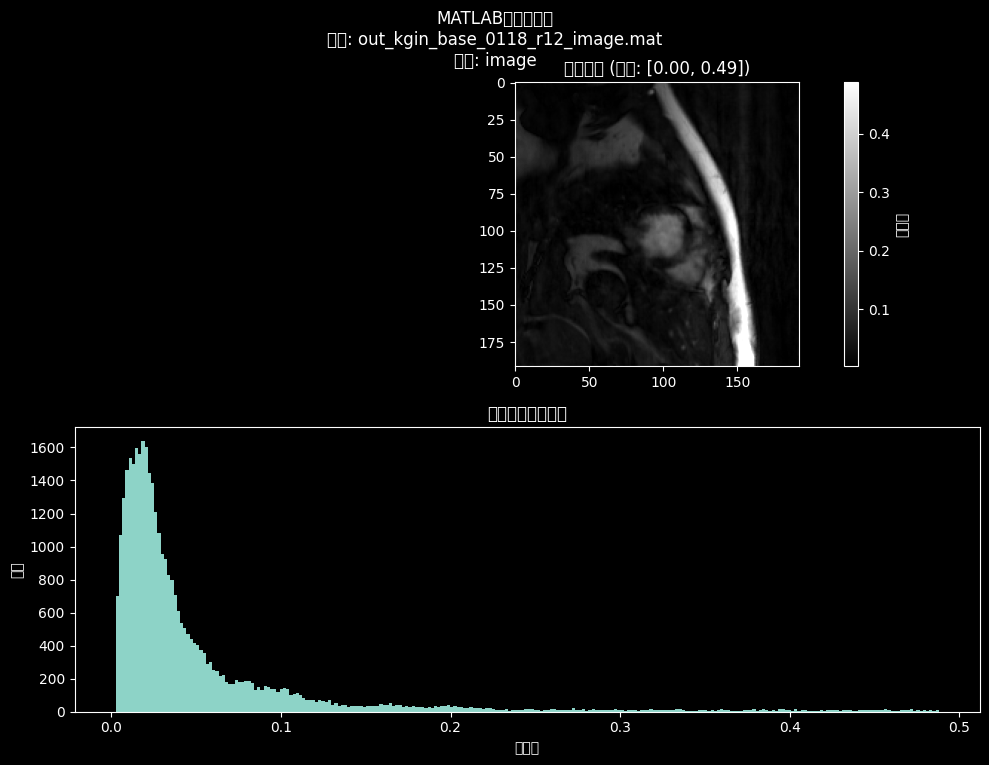

In [22]:
# 使用示例
if __name__ == "__main__":
    image_file_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12/out_kgin_base_0118_r12_image.mat'
    load_and_display_mat_image(image_file_path)

(118, 18, 192, 192) float32


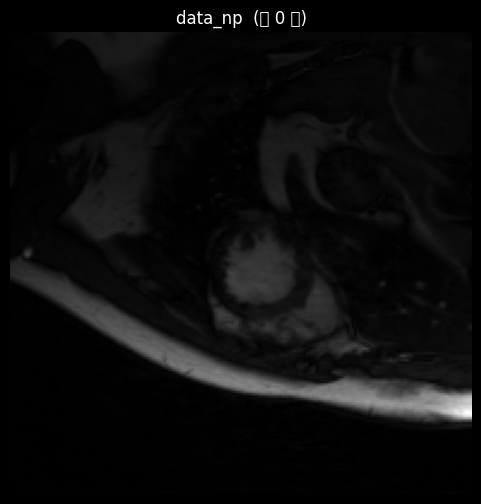

In [ ]:
##
file_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/converted_images/out_kgin_base_1209_r8_recon.npy'
data = np.load(file_path) 
print(data.shape,data.dtype) #(118, 18, 192, 192) float32
# train_t_np = np.abs(train_t)  # 取模
data_np = data[80,15,:,:]
# 显示kspace的数据
plt.figure(figsize=(6, 6))
plt.imshow(data_np, cmap='gray')  # 使用灰度颜色映射
plt.title("data_np  (第 0 帧)")
plt.axis('off')
plt.show()